# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

# Пояснение

Задача - с помощью метода градиентного спуска подобрать вектор Тэта так, чтобы *максимально точно апроксимировать Y.* Исходные данные имеют 4 признака. Линейная модель помимо 4 компонент, зависящих от признаков, имеет один свободный член - "bias". Чтобы его учесть, *в матрицу Х добавим стобец единиц*, и *вектор Тэта будем генерировать с учетом этого* (размерность будет 5, а не 4). В качестве функции ошибок loss берем *MSE*. Меру качества также, будем оценивать с помощью *MSE*.

# Код

In [24]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from scipy.stats import linregress

In [25]:
%matplotlib inline

# Считывание и проверка на корреляцию данных

### Корреляция признаков в X

In [26]:
Atr = np.load('./X_train.npy')
Ytr = np.load('./y_train.npy')

for i in range(3, -1, -1):
    for j in range(i):
        print(j + 1, i + 1, linregress(Atr[:, i], Atr[:, j]).rvalue)

1 4 0.8810066394101135
2 4 0.880309519991988
3 4 0.018993957650159453
1 3 0.009249554165431597
2 3 0.009691498517618875
1 2 0.9993083153367507


Можем заметить, что 1 и 2 признаки имеют очень большой коэффициент корреляции (>0,99), а значит они линейно зависимы. В этом случае, мы имеем право убрать один из этих признаков.

In [27]:
Xtr = Atr[:, 1:]

### Корреляция признков X и Y

In [28]:
for i in range(3):
    print(i, linregress(Xtr[:, i], Ytr.T).rvalue)

0 0.5973775791838263
1 0.5995671883667846
2 0.7870922084362534


In [29]:
Xtr[:, 0][:, np.newaxis]

array([[-1.6392424 ],
       [-5.49543837],
       [-4.59480326],
       ...,
       [ 3.7384779 ],
       [ 3.90722646],
       [ 6.61282838]])

In [30]:
Ytr

array([[ 2.46862556],
       [ 9.99814558],
       [ 9.27899993],
       ...,
       [ 4.45355455],
       [ 4.99679352],
       [36.40018469]])

### Распределение признаков X

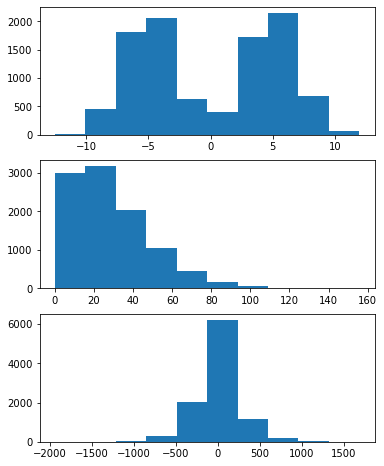

In [31]:
fig, axs = plt.subplots(3, 1)
fig.set_figheight(8)
for i in range(3):
    axs[i].hist(Xtr[:, i][:, np.newaxis])

### Распределение Y

(array([6.000e+00, 4.700e+01, 7.647e+03, 1.519e+03, 5.130e+02, 1.610e+02,
        6.800e+01, 2.500e+01, 1.100e+01, 3.000e+00]),
 array([-57.87273713, -32.73345381,  -7.59417049,  17.54511283,
         42.68439615,  67.82367947,  92.96296279, 118.10224611,
        143.24152943, 168.38081275, 193.52009607]),
 <a list of 10 Patch objects>)

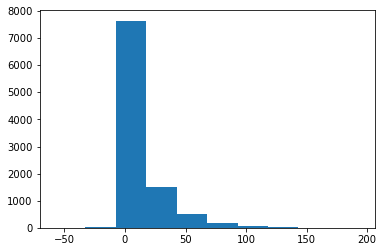

In [32]:
fig, axs = plt.subplots()
axs.hist(Ytr)

In [33]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [34]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()
    
    def forward(self, y_pred, y_true):
        loss_value = (y_pred - y_true)**2
                
        return np.sum(loss_value) / y_pred.shape[0]
    
    
    def backward(self, y_pred, y_true):
        partial_grad = 2 * (y_pred - y_true)
        
        return partial_grad

In [35]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None
    
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, X):
        partial_grad = X.T
        
        return partial_grad
    
    def forward(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        if (self.theta is None):
            self.theta = np.random.rand(X.shape[1], 1)

        y_pred = np.dot(X, self.theta)
        
        return y_pred

In [36]:
def train_loop(X, y, model, loss_fn, epochs=100):

    X = (X - X.mean(axis=0))/ X.std(axis=0)
    X = np.c_[X, np.ones(10000)]
    
    loss_history = []
    pbar = tqdm(total=epochs)
    for epoch in range(epochs):
        lr = 0.01
        loss_value = loss_fn.forward(model.forward(X), y)
        grad = np.dot(model.backward(X), loss_fn.backward(model.forward(X), y))
        
        model.theta -= lr * grad / y.shape[0]
        
        loss_history.append(loss_value)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
        
    pbar.close()
    return loss_history

In [37]:
obj_fn = loss()
lr_model = linear_regression()
loss_history = train_loop(Xtr, Ytr, lr_model, obj_fn, epochs=1000)

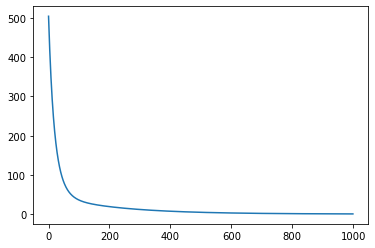

In [38]:
plt.plot(loss_history)